## Environment setup 

In [23]:
# import shutil

# # Define source and destination paths
# dst = "/Users/eugenewoo/evaluating_evals/gemini_test.ipynb"
# src = "/Users/eugenewoo/gemini_test.ipynb"

# # Make sure destination folder exists
# os.makedirs(os.path.dirname(dst), exist_ok=True)

# # Move the file
# shutil.move(src, dst)

'/Users/eugenewoo/evaluating_evals/gemini_test.ipynb'

In [57]:
import os

os.chdir("/Users/eugenewoo/evaluating_evals/")
os.getcwd()

'/Users/eugenewoo/evaluating_evals'

In [58]:
pip install -q ipython matplotlib pycm scikit-learn tiktoken nest_asyncio dotenv vertexai "google-cloud-aiplatform>=1.33.0" "google-generativeai" tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
# # Create .env file
# folder_path = os.getcwd()

# env_path = os.path.join(folder_path, ".env")
# with open(env_path, "w") as f:
#     f.write('GEMINI_API_KEY="your_gemini_api_key_here"\n')
#     f.write("DEBUG=True\n")

# # Verify
# !cat /Users/eugenewoo/.env

In [ ]:
from dotenv import load_dotenv
import google.generativeai as genai

# Configure Gemini API key
load_dotenv()
os.environ.get("GEMINI_API_KEY")
genai.configure()

# Verify API key
# !cat /Users/eugenewoo/.env

## Setup Gemini model and Benchmark dataset for classification evaluation

In [61]:
# Create the model instance and assign to a variable
model = genai.GenerativeModel("gemini-2.0-flash")

# Create a generation function using the model variable
prompt = "Explain the concept of reinforcement learning in simple terms."

# Use the variable to generate a response
response = model.generate_content(prompt)

# Output the generated text
print(response.text)

Imagine you're training a dog. You want the dog to learn to sit.

*   **Agent:** The dog is the "agent" – the thing learning.
*   **Environment:** The room you're in is the "environment" – the world the agent interacts with.
*   **Actions:** The dog can "act" by sitting, standing, lying down, etc.
*   **Reward:** When the dog sits, you give it a treat (the "reward"). If it does anything else, it gets nothing.

**Reinforcement learning (RL) is like teaching the dog to sit using rewards.** The dog tries different actions (sitting, standing, etc.). When it accidentally sits and gets a treat, it learns: "Okay, sitting is a good thing to do in this environment because it gives me a reward!"

Over time, the dog tries sitting more often because it's more likely to get a treat. It's learned the "policy" (the best way to act) that maximizes its reward.

**In more formal terms:**

*   **The goal of RL is to train an agent to make a sequence of decisions that maximize a cumulative reward.**
*   T

In [62]:
df_sample = pd.read_csv("benchmark_samples.csv")
df_sample.head()

,query_id,input,document_title,reference,document_text_with_emphasis,relevant
0,Q2717,what is pci Interface,Conventional PCI,"Conventional PCI (PCI is an initialism formed from Peripheral Component Interconnect, part of the PCI Local Bus standard and often shortened to just PCI) is a local computer bus for attaching hardware devices in a computer . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in universal serial bus and PCI Express versions.","CONVENTIONAL PCI (PCI IS AN INITIALISM FORMED FROM PERIPHERAL COMPONENT INTERCONNECT, PART OF THE PCI LOCAL BUS STANDARD AND OFTEN SHORTENED TO JUST PCI) IS A LOCAL COMPUTER BUS FOR ATTACHING HARDWARE DEVICES IN A COMPUTER . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in

## Run relevance classifications with Gemini

In [63]:
import nest_asyncio

nest_asyncio.apply() #Enables async request submission in notebooks to speed up inference

In [64]:
import pandas as pd
import time
import re
import json

# 1. Relevance classification evaluation criteria
evaluation_prompt_template = """
Compare the Input text to the Reference text. Determine whether the Reference text contains information that answers the question in the Input text.

Respond ONLY in JSON format with the following keys:
- "label": either "True" or "False" but nothing else. True means the reference text is relevant and false means it is not relevant.
- "critique": a detailed explanation of the label

Example:
{{
  "label": "False",
  "critique": "The response does not directly answer the question of who killed Julius Caesar. Instead, it provides a detailed biography of Julius Caesar, including his life, achievements, and death. While it mentions that Caesar was assassinated by a group of senators led by Marcus Junius Brutus, this information is buried within a lengthy passage and does not clearly address the user's question. To improve, the response should focus on providing a clear and concise answer to the user's question, rather than providing unnecessary background information.
}}

Question: {model_input}

Reference: {reference}

Answer:
"""

# 2. Define the classifier function

def evaluate_row(row):
    prompt = evaluation_prompt_template.format(
        model_input=row["input"],
        reference=row["reference"],
        # model_output=row["model_output"]
    )

    try:
        response = model.generate_content(prompt)
        text = response.text.strip()

        # Try to extract valid JSON block
        json_str_match = re.search(r'\{.*\}', text, re.DOTALL)
        if not json_str_match:
            raise ValueError("No JSON found in model response")

        json_data = json.loads(json_str_match.group())
        label = json_data.get("label", "Unknown")
        critique = json_data.get("critique", "No critique")

        return {
            "model_input": row["input"],
            "model_output": row["reference"],
            "critique": critique,
            "score": label
        }

    except Exception as e:
        return {
            "model_input": row["input"],
            "model_output": row["reference"],
            "critique": f"Error: {e}",
            "score": "Error"
        }

# 3. Iterate and evaluate all rows
results_list = []

for _, row in df_sample.iterrows():
    result_dict = {"evaluation": evaluate_row(row)}
    results_list.append({
        "model_input": row["input"],
        "model_output": row["reference"],
        "critique": result_dict['evaluation']['critique'],
        "score": result_dict['evaluation']['score'],
    })
    time.sleep(0.5)  # Optional delay

In [65]:
# 4. Convert to dataframe
results_df = pd.DataFrame(results_list)
display(results_df.head())

,model_input,model_output,critique,score
0,what is pci Interface,"Conventional PCI (PCI is an initialism formed from Peripheral Component Interconnect, part of the PCI Local Bus standard and often shortened to just PCI) is a local computer bus for attaching hardware devices in a computer . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in universal serial bus and PCI Express versions.","The reference text directly answers the question by defining what PCI (Peripheral Component Interconnect) is and describing its purpose and function within a computer system. It details its role as a local computer bus for attaching hardware devices, its relationship to the processor bus, and the types of devices that utilize PCI.",True
1,who created earth day,"The Earth Day Flag , the latest proposal of John McConnell for a flag of Earth Day Earth Day is an annual event, celebrated on April 22, on which events are held worldwide to demonstrate support for environmental protection. It was first celebrated in 1970, and is now coordinated globally by the Earth Day Network , and celebrated in more than 192 countries each year. In 1969 at a UNESCO Conference in San Francisco, the date proposed was March 21, 1970, the first day of spring in the northern hemisphere. This day of nature's equipoise was later sanctioned in a Proclamation signed by Secretary General U Thant at the United Nations . A month later a separate Earth Day was founded by United States Senator Gaylord Nelson as an environmental teach-in first held on April 22, 1970. Nelson was later awarded the Presidential Medal of Freedom Award in recognition of his work. While this April 22 Earth Day was focused on the United States, an organization launched by Denis Hayes , who was the original national coordinator in 1970, took it international in 1990 and organized events in 141 nations. Numerous communities celebrate Earth Week, an entire week of activities focused on environmental issues.","The reference text directly answers the question of who created Earth Day. It states that United States Senator Gaylord Nelson founded Earth Day as an environmental teach-in first held on April 22, 1970. It also mentions John McConnell's proposal for a flag of Earth Day and Denis Hayes taking it international, but Nelson is identified as the founder.",True
2,what caribbean island is part of Franc

## Analyse accuracy of Gemini's evaluation

In [66]:
relevance_classifications=results_df["score"].tolist()
# display(relevance_classifications)

true_labels = df_sample["relevant"].tolist()
# display(true_labels)

              precision    recall  f1-score   support

        True       0.53      0.90      0.67        10
       False       0.92      0.60      0.73        20

    accuracy                           0.70        30
   macro avg       0.73      0.75      0.70        30
weighted avg       0.79      0.70      0.71        30



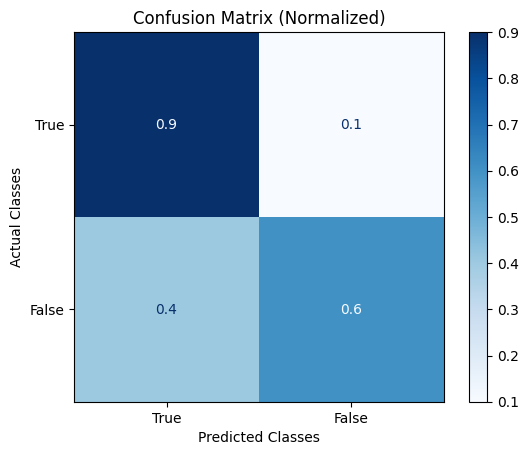

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=['True','False']
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

true_labels = [str(x) for x in true_labels]
relevance_classifications = [str(x) for x in relevance_classifications]
print(classification_report(true_labels, relevance_classifications, labels=['True', 'False']))

## Troubleshooting (IGNORE)

In [68]:
# input="who killed julius caesar",
# reference="Gaius Julius Caesar (, July 100 BC – 15 March 44 BC) was a Roman general , statesman , Consul and notable author of Latin prose. He played a critical role in the events that led to the demise of the Roman Republic and the rise of the Roman Empire . In 60 BC, Caesar, Crassus and Pompey formed a political alliance that was to dominate Roman politics for several years. Their attempts to amass power through populist tactics were opposed by the conservative elite within the Roman Senate , among them Cato the Younger with the frequent support of Cicero . Caesar's conquest of Gaul , completed by 51 BC, extended Rome's territory to the English Channel and the Rhine . Caesar became the first Roman general to cross both when he built a bridge across the Rhine and conducted the first invasion of Britain . These achievements granted him unmatched military power and threatened to eclipse the standing of Pompey, who had realigned himself with the Senate after the death of Crassus in 53 BC. With the Gallic Wars concluded, the Senate ordered Caesar to lay down his military command and return to Rome. Caesar refused, and marked his defiance in 49 BC by crossing the Rubicon with a legion , leaving his province and illegally entering Roman territory under arms. Civil war resulted, from which he emerged as the unrivaled leader of Rome. After assuming control of government, Caesar began a program of social and governmental reforms, including the creation of the Julian calendar . He centralised the bureaucracy of the Republic and was eventually proclaimed 'dictator in perpetuity'. But the underlying political conflicts had not been resolved, and on the Ides of March (15 March) 44 BC, Caesar was assassinated by a group of senators led by Marcus Junius Brutus . A new series of civil wars broke out, and the constitutional government of the Republic was never restored. Caesar's adopted heir Octavian, later known as Augustus , rose to sole power, and the era of the Roman Empire began. Much of Caesar's life is known from his own accounts of his military campaigns, and from other contemporary sources, mainly the letters and speeches of Cicero and the historical writings of Sallust . The later biographies of Caesar by Suetonius and Plutarch are also major sources. Caesar is deemed to be one of the greatest military commanders of history.",

# prompt = evaluation_prompt_template.format(
#         model_input="input",
#         reference="reference",
#         # model_output=row["model_output"]
#     )


# response = model.generate_content(prompt)
# text = response.text.strip()

# print(text)